In [1]:
import torch
from vit_pytorch.efficient import ViT
from nystrom_attention import Nystromformer
from vit_pytorch import MAE
import torchvision 
from tqdm import tqdm
from torchvision import transforms
import torch
from torch import nn
import torch.nn.functional as F
from einops import repeat

from vit_pytorch.vit import Transformer
from torch import nn
efficient_transformer = Nystromformer(
    dim = 128,
    depth = 6,
    heads = 4,
    num_landmarks = 256
)

v_n = ViT(
    dim = 128,
    image_size = 112,
    patch_size = 16,
    num_classes = 256,
    transformer = efficient_transformer
)
mae_nystrom = MAE(
    encoder = v_n,
    masking_ratio = 0.5,   # the paper recommended 75% masked patches
    decoder_dim = 128,      # paper showed good results with just 512
    decoder_depth = 4       # anywhere from 1 to 8
)

In [2]:
class MAE(nn.Module):
    def __init__(
        self,
        *,
        encoder,
        decoder_dim,
        masking_ratio = 0.75,
        decoder_depth = 1,
        decoder_heads = 8,
        decoder_dim_head = 64
    ):
        super().__init__()
        assert masking_ratio > 0 and masking_ratio < 1, 'masking ratio must be kept between 0 and 1'
        self.masking_ratio = masking_ratio

        # extract some hyperparameters and functions from encoder (vision transformer to be trained)

        self.encoder = encoder
        num_patches, encoder_dim = encoder.pos_embedding.shape[-2:]
        self.to_patch, self.patch_to_emb = encoder.to_patch_embedding[:2]
        pixel_values_per_patch = self.patch_to_emb.weight.shape[-1]

        # decoder parameters

        self.enc_to_dec = nn.Linear(encoder_dim, decoder_dim) if encoder_dim != decoder_dim else nn.Identity()
        self.mask_token = nn.Parameter(torch.randn(decoder_dim))
        self.decoder = Transformer(dim = decoder_dim, depth = decoder_depth, heads = decoder_heads, dim_head = decoder_dim_head, mlp_dim = decoder_dim * 4)
        self.decoder_pos_emb = nn.Embedding(num_patches, decoder_dim)
        self.to_pixels = nn.Linear(decoder_dim, pixel_values_per_patch)

    def forward(self, img):
        device = img.device

        # get patches

        patches = self.to_patch(img)
        batch, num_patches, *_ = patches.shape

        # patch to encoder tokens and add positions

        tokens = self.patch_to_emb(patches)
        tokens = tokens + self.encoder.pos_embedding[:, 1:(num_patches + 1)]

        # calculate of patches needed to be masked, and get random indices, dividing it up for mask vs unmasked

        num_masked = int(self.masking_ratio * num_patches)
        rand_indices = torch.rand(batch, num_patches, device = device).argsort(dim = -1)
        masked_indices, unmasked_indices = rand_indices[:, :num_masked], rand_indices[:, num_masked:]

        # get the unmasked tokens to be encoded

        batch_range = torch.arange(batch, device = device)[:, None]
        tokens = tokens[batch_range, unmasked_indices]

        # get the patches to be masked for the final reconstruction loss

        masked_patches = patches[batch_range, masked_indices]

        # attend with vision transformer

        encoded_tokens = self.encoder.transformer(tokens)

        # project encoder to decoder dimensions, if they are not equal - the paper says you can get away with a smaller dimension for decoder

        decoder_tokens = self.enc_to_dec(encoded_tokens)

        # reapply decoder position embedding to unmasked tokens

        decoder_tokens = decoder_tokens + self.decoder_pos_emb(unmasked_indices)

        # repeat mask tokens for number of masked, and add the positions using the masked indices derived above

        mask_tokens = repeat(self.mask_token, 'd -> b n d', b = batch, n = num_masked)
        mask_tokens = mask_tokens + self.decoder_pos_emb(masked_indices)

        # concat the masked tokens to the decoder tokens and attend with decoder

        decoder_tokens = torch.cat((mask_tokens, decoder_tokens), dim = 1)
        decoded_tokens = self.decoder(decoder_tokens)

        # splice out the mask tokens and project to pixel values

        mask_tokens = decoded_tokens[:, :num_masked]
        pred_pixel_values = self.to_pixels(mask_tokens)

        # calculate reconstruction loss

        recon_loss = F.mse_loss(pred_pixel_values, masked_patches)
        return recon_loss, pred_pixel_values, masked_patches

In [3]:
from vit_pytorch import ViT as ViT2
v = ViT2(
    image_size = 112,
    patch_size = 16,
    num_classes = 1000,
    dim = 256,
    depth = 6,
    heads = 8,
    mlp_dim = 512
)
mae = MAE(
    encoder = v,
    masking_ratio = 0.25,   # the paper recommended 75% masked patches
    decoder_dim = 128,      # paper showed good results with just 512
    decoder_depth = 4       # anywhere from 1 to 8
)

In [4]:
mae = mae.cuda()

mae_nystrom = mae_nystrom.cuda()

In [5]:


transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((112,112))
])
dataset = torchvision.datasets.ImageFolder('~/data/imagenet', transform=transform)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    persistent_workers=True,
    prefetch_factor=2
)

In [6]:
def eval(model):
    tl = 0
    for batch, _ in tqdm(dataloader):
        loss = model(batch.cuda())
        tl += loss.sum().item()
    return tl

In [7]:
model = torch.load('trained-vit_9.pt')
sd = torch.load('trained-vit_9.pt')
mae.load_state_dict({k[len('module.'):]:v for k,v in sd.items()})

<All keys matched successfully>

In [7]:
eval(mae)

100%|██████████| 6250/6250 [02:20<00:00, 44.61it/s]


127.05671374313533

In [10]:
import torch.nn.utils.prune as prune

In [11]:
layers = [(module, 'weight') for module in mae.modules() if isinstance(module, torch.nn.Linear)]
prune.global_unstructured(
    layers,
    pruning_method=prune.L1Unstructured,
    amount=0.5,
)

In [12]:
eval(mae)


100%|██████████| 6250/6250 [02:20<00:00, 44.64it/s]


295.5383972302079

In [49]:
torch.__version__

'1.10.1'

In [31]:
layers = [(module, 'weight') for module in mae_nystrom.modules() if isinstance(module, torch.nn.Linear)]
prune.global_unstructured(
    layers,
    pruning_method=prune.L1Unstructured,
    amount=0.5,
)

In [8]:
def val(model):
    tl = 0
    for batch, _ in tqdm(dataloader):
        return model(batch.cuda())


In [9]:
out = val(mae)

  0%|          | 0/6250 [00:00<?, ?it/s]


In [10]:
out[1].shape

torch.Size([8, 12, 768])

In [11]:
out[2].shape

torch.Size([8, 12, 768])

In [12]:
import matplotlib.pyplot as plt

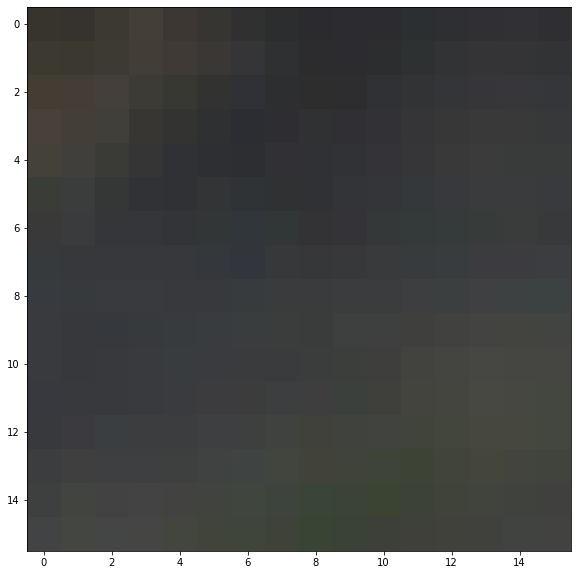

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(out[2][0].reshape((12, 16,16,3))[0].cpu())

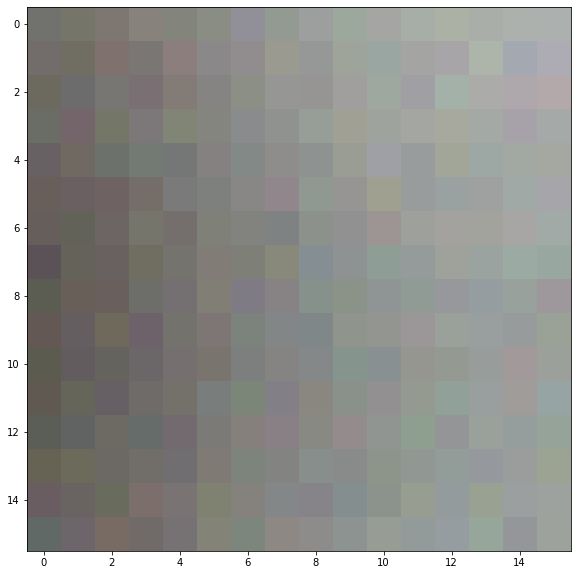

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(out[1][0].detach().cpu().reshape((12,16,16,3))[0].cpu())

In [15]:

out[2][0].reshape((12, 16,16,3))

tensor([[[[0.2184, 0.2066, 0.1822],
          [0.2141, 0.2024, 0.1809],
          [0.2373, 0.2255, 0.1981],
          ...,
          [0.1902, 0.1872, 0.2041],
          [0.1937, 0.1907, 0.2075],
          [0.1861, 0.1878, 0.2028]],

         [[0.2372, 0.2254, 0.1901],
          [0.2352, 0.2235, 0.1882],
          [0.2430, 0.2313, 0.2038],
          ...,
          [0.2078, 0.2078, 0.2156],
          [0.2078, 0.2078, 0.2157],
          [0.1926, 0.2039, 0.2093]],

         [[0.2633, 0.2397, 0.2043],
          [0.2651, 0.2415, 0.2106],
          [0.2677, 0.2500, 0.2314],
          ...,
          [0.2150, 0.2121, 0.2288],
          [0.2167, 0.2146, 0.2313],
          [0.2080, 0.2148, 0.2276]],

         ...,

         [[0.2360, 0.2401, 0.2474],
          [0.2481, 0.2481, 0.2473],
          [0.2440, 0.2475, 0.2553],
          ...,
          [0.2667, 0.2775, 0.2368],
          [0.2663, 0.2703, 0.2459],
          [0.2558, 0.2650, 0.2427]],

         [[0.2464, 0.2523, 0.2541],
          [0.2611